In [3]:
import datetime
import xarray as xr
import numpy as np
import dask
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import cftime
print(xwmb.__version__, xwmt.__version__, xgcm.__version__)

0.1.0 0.1.1 0.8.2.dev15+g7492277


In [2]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"
ds = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily.*.nc", chunks={"time":1})
ds = ds.isel(yh=slice(1, None), yq=slice(None, -1), xh=slice(1,None), xq=slice(None, -1)) # realign cell center/corner coordinates

snap = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1})
# Rename snapshot time coordinates to time_bounds so they can later be merged with ds
snap = snap.rename({
    **{'time': 'time_bounds'},
    **{v: f"{v}_bounds" for v in snap.data_vars}
    })

static = xr.open_dataset("/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc")

In [7]:
mt_path = "/pub/mariant3/WarmWaterMasses/data/"
labels = xr.open_dataset(f"{mt_path}ocetracv9/ocetrac-v9-blobs-tos-t1-r1-msq0-01860315-01891214-region.nc").blobs.rename('event_mask')

ids = np.unique(labels.values[~np.isnan(labels.values)])
#Because we want to run the budgets for all individual events, we will not get rid of 1 day events. Instead, we sort the events based on their area (largest to smallest)
# area_array = [(labels == id).any("time").sum(["xh", "yh"]).values for id in ids]
# ids = [id for _, id in sorted(zip(area_array, ids), reverse=True)]

mhw = 373

print('----------------- zooming into the each event -----------------')
event_mask = (labels == mhw)

# Zoom in on time period of event (+ 1 day before and 1 day after)
event_times = event_mask.time[event_mask.any(["xh", "yh"]).compute()]

window_size = min(3, len(event_times))

event_mask = event_mask.sel(time=slice(
    event_times[ 0],
    event_times[-1],
))
print('----------------- creating a 3-day dynamic mask -----------------')

# Create centered 3-day rolling cumulative mask
event_mask = (
    event_mask.rolling({"time":window_size}, min_periods=1, center=True)
    .max("time")
    .fillna(0.)
    .astype("float64")
)

print('----------------- merging and realigning-----------------')

# Merge budget diagnostics with the event mask
ds_event = xr.merge([ds, event_mask], join='inner')

# Get snapshots that bound the event
snap_event = snap.sel(
    time_bounds=slice(
        ds_event.time[0].values + datetime.timedelta(days = -1),
        ds_event.time[-1].values + datetime.timedelta(days = 1)
    )
)

ds_event = xr.merge([ds_event, snap_event, static], join='inner')

xh_mask = ds_event.event_mask.any(["time","yh"])
xh_mask_where = np.where(xh_mask)[0]
xh_mask = np.arange(xh_mask_where[0],xh_mask_where[-1]+1,1)

yh_mask = ds_event.event_mask.any(["time","xh"])
yh_mask_where = np.where(yh_mask)[0]
yh_mask = np.arange(yh_mask_where[0],yh_mask_where[-1]+1,1)

# Zoom in on region of the actual event
xh_event = ds_event.xh[xh_mask]
yh_event = ds_event.yh[yh_mask]

ds_event = ds_event.sel(xh=xh_event, yh=yh_event)

 # # # Realign tracer center/corner coordinates because inner "join" only shrinks the ("xh", "yh") dimensions!
xq_inner = ds_event.xq.sel(xq=slice(ds_event.xh[0], ds_event.xh[-1]))
xq_islice = (np.abs(ds_event.xq - xq_inner[0]).argmin().values - 1, np.abs(ds_event.xq - xq_inner[-1]).argmin().values + 2)
yq_inner = ds_event.yq.sel(yq=slice(ds_event.yh[0], ds_event.yh[-1]))
yq_islice = (np.abs(ds_event.yq - yq_inner[0]).argmin().values - 1, np.abs(ds_event.yq - yq_inner[-1]).argmin().values + 2)

ds_event = ds_event.isel(xq=slice(*xq_islice), yq=slice(*yq_islice))
print('----------------- Adding core coordinates of static to ds_event -----------------')

----------------- zooming into the each event -----------------
----------------- creating a 3-day dynamic mask -----------------
----------------- merging and realigning-----------------
----------------- Adding core coordinates of static to ds_event -----------------


In [8]:
def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})
    
ds_event = add_estimated_layer_interfaces(ds_event)

ds_event = ds_event.assign_coords({
    "areacello": xr.DataArray(ds_event["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "yq": xr.DataArray(ds_event["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(ds_event["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(ds_event["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(ds_event["geolat_c"].values, dims=('yq', 'xq',)),
    })

coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'}
}

metrics = {
    ('X','Y'): "areacello", # Required for area-integration
    }

ds_event['tos'] = ds_event['thetao'].isel(zl=0)

In [40]:
import numpy as np
import regionate
import matplotlib.pyplot as plt
import warnings

print('----------------- creating _calc_temperature_wmt function -----------------')

def _calc_temperature_wmt(ds_event):
    lam = "heat"
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        grid = xgcm.Grid(ds_event.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)
        wm = xwmt.WaterMass(grid)
        
        import xbudget
        budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
        del budgets_dict['salt']['lhs']
        del budgets_dict['salt']['rhs']
        
        xbudget.collect_budgets(grid, budgets_dict)
        
        wmb = xwmb.WaterMassBudget(
            grid,
            budgets_dict,
            ds_event.event_mask.squeeze() if ds_event.event_mask.squeeze().any() else None
            )
        #display(wmb.grid._ds)
        wmb.mass_budget(lam, greater_than=True, default_bins=True)
        # display(wmb.grid._ds)
    return wmb.wmt

def sel_times(ds, t):
    return ds.sel(
        time = t.expand_dims("time"),
        time_bounds = slice(
            t + datetime.timedelta(days = -1),
            t + datetime.timedelta(days = 1)
        )
    )
    
print('----------------- getting ready to define wmt -----------------')

wmt = xr.concat([
    _calc_temperature_wmt(sel_times(ds_event, t))
    for t in ds_event.time
    ], dim="time")
# display(wmt)
# start = wmt.time.values.astype('datetime64[D]')[0]
# end = wmt.time.values.astype('datetime64[D]')[-1]
# print(f'Event {mhw} starts on {start} and ends on {end}')
# print(wmt.time.values)

print('----------------- getting ready to load wmt -----------------')
# wmt.load()
print('-----------------loaded wmt -----------------')
# print('saving nc file...')
# print(f"wmt_mhw_event_full.to_netcdf(f'/pub/mariant3/WarmWaterMasses/data/budgets/rolling_budgets/rolling_budgets_v9/event-roll-budget_id-{int(mhw)}-{start}-{end}.nc'), mode='w'")
# wmt.to_netcdf(f'/pub/mariant3/WarmWaterMasses/data/budgets/rolling_budgets/rolling_budgets_v9/event-roll-budget_id-{int(mhw)}_{start}-{end}.nc', mode='w')
# print(f'...saved nc file for mhw {mhw}!')

----------------- creating _calc_temperature_wmt function -----------------
----------------- getting ready to define wmt -----------------
ERROR! Session/line number was not unique in database. History logging moved to new session 2177


<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou


KeyboardInterrupt



In [67]:
t = ds_event.time[100]
t

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(186, 8, 8, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 0186-08-08 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds

In [68]:
test_wmt = _calc_temperature_wmt(sel_times(ds_event, t))

<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time: 1,
                                                                                                             xh: 110,
                                                                                                             yh: 61,
                                                                                                             zl: 75,
                                                                                                             xq: 111,
                                                                                                             yq: 62,
                                                                                                             time_bounds: 2,
                                                                                                             zi: 76,
                                                                                                             thetao_l_target: 440,
                                                                                                             thetao_i_target: 441)
Coordinates: (12/18)
  * time                                                                                                    (time) object ...
  * xh                                                                                                      (xh) float64 ...
  * yh                                                                                                      (yh) float64 ...
  * zl                                                                                                      (zl) float64 ...
  * xq                                                                                                      (xq) float64 ...
  * time_bounds                                                                                             (time_bounds) object ...
    ...                                                                                                      ...
  * zi                                                                                                      (zi) float64 ...
    lon                                                                                                     (yh, xh) float32 ...
    lat                                                                                                     (yh, xh) float32 ...
  * yq                                                                                                      (yq) float64 ...
  * thetao_l_target                                                                                         (thetao_l_target) float64 ...
  * thetao_i_target                                                                                         (thetao_i_target) float64 ...
Data variables: (12/110)
    S_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_advection_xy                                                                                          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    T_adx                                                                                                   (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 61, 111), meta=np.ndarray>
    T_ady                                                                                                   (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 62, 110), meta=np.ndarray>
    Th_tendency_vert_remap                                                                                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 61, 110), meta=np.ndarray>
    bou

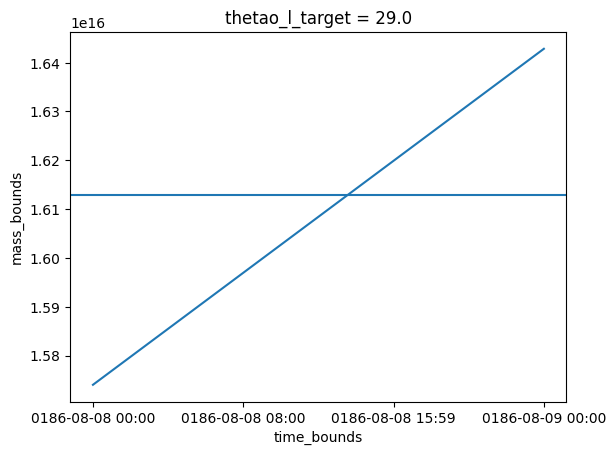

In [69]:
test_wmt.sel(thetao_l_target=29, method='nearest').mass_bounds.plot()
plt.axhline(test_wmt.layer_mass.where(wmt.thetao_l_target >= 29).sum('thetao_l_target'))

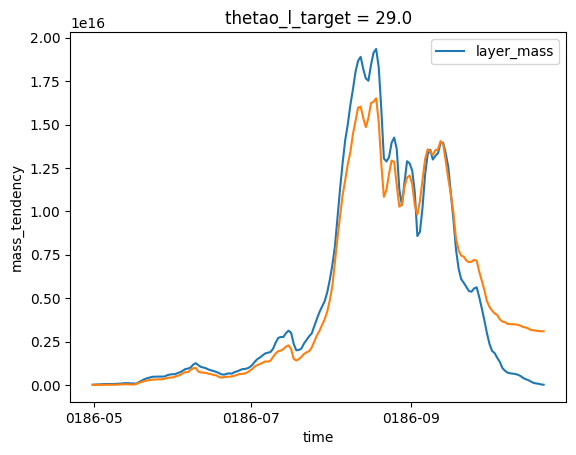

In [70]:
deltaM = wmt.layer_mass.where(wmt.thetao_l_target >= 29).sum("thetao_l_target")
deltaM.plot(label="layer_mass")

dmdt = (wmt.mass_tendency * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest')
dmdt.plot()
Gsurf = (-wmt['boundary_fluxes'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest')
# Gsurf.plot()
diffusion = (-wmt['diffusion'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest')
spur = (-wmt['spurious_numerical_mixing'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest')

mass_source = (wmt['mass_source'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest')
# mass_source.plot(label=r"$-\langle \mathcal{S} \rangle$")

mass_transport = (wmt.convergent_mass_transport * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest')
# mass_transport.plot(label="mass_transport")

Gmix= diffusion+spur
# Gmix.plot()

all_terms = Gsurf + Gmix + mass_source + mass_transport
# all_terms.plot(label=r"$\langle \mathcal{G}^{surf}+\mathcal{G}^{mix} \rangle$")
plt.legend()

In [38]:
wmb

NameError: name 'wmb' is not defined

In [37]:
wmt

<xarray.Dataset>
Dimensions:                                    (time: 176,
                                                thetao_l_target: 440,
                                                thetao_i_target: 441, xh: 110,
                                                yh: 61)
Coordinates:
  * time                                       (time) object 0186-04-30 12:00...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * xh                                         (xh) float64 -97.58 ... -69.91
  * yh                                         (yh) float64 16.52 ... 30.24
    geolat                                     (yh, xh) float32 16.52 ... 30.24
    geolon                                     (yh, xh) float32 -97.62 ... -7...
    areacello                                  (yh, xh) float32 7.121e+08 ......
    deptho                                     (yh, xh) float32 nan ... 5.426...
    lon                                        (yh, xh) float32 -97.62 ... -7...
    lat                                        (yh, xh) float32 16.52 ... 30.24
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
Data variables: (12/20)
    diffusion                                  (time, thetao_l_target) float64 ...
    advection                                  (time, thetao_l_target) float64 ...
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 ...
    bottom_flux                                (time, thetao_l_target) float64 ...
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 ...
    frazil_ice                                 (time, thetao_l_target) float64 ...
    ...                                         ...
    mass_tendency                              (time, thetao_l_target) float64 ...
    dt                                         (time) float64 8.64e+04 ... 8....
    Leibniz_material_derivative                (time, thetao_l_target) float64 ...
    spurious_numerical_mixing                  (time, thetao_l_target) float64 ...
    advection_plus_BC                          (time, thetao_l_target) float64 ...
    diabatic_advection                         (time, thetao_l_target) float64 ...

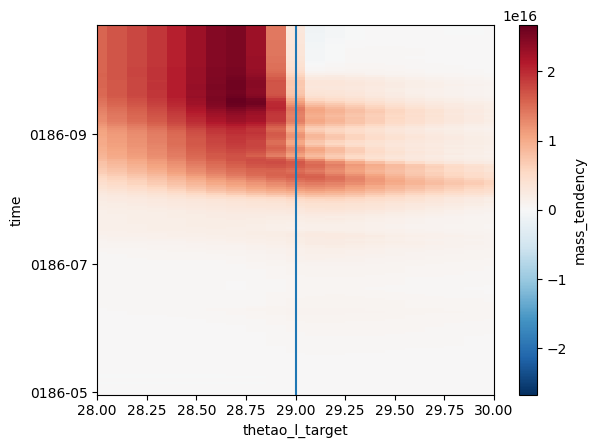

In [23]:
(wmt.mass_tendency * 86400).cumsum('time').plot()
plt.xlim(28,30)
plt.axvline(29)